In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sstat
from mpmath import mp
import math
import random
from scipy.stats import multivariate_normal

psd = pd.DataFrame
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

Generiamo 1000 sample da una normale:

\begin{equation*}
\begin{aligned}
    y_{obs} &\sim \mathcal{N}(\mu_{obs}, σ_{obs} ^2) \\
\end{aligned}
\end{equation*}

e scegliamo come modello:

\begin{equation*}
\begin{aligned}
    y_i | \mu &\sim ^{iid} \mathcal{N}(\mu, \sigma_{obs} ^2)  \\
    \mu & \sim \mathcal{N}(\mu_0, \sigma_0^2)
\end{aligned}
\end{equation*}

$\sigma_{obs}$ noto

$\mu_0, \sigma_0$ fissati

$\mathscr{L}(y_i|\mu)$:

In [2]:
def single_lik(mu,tau):
   return tfd.Normal(mu,np.sqrt(1/tau))

# $\pi(\mu)$:

In [ ]:
#c =
#d =
#mu0 =
#k =

In [3]:
def prior_mu():
    return tfd.Normal(mu0,1/tau0)

In [4]:
def prior_tau():
    return tfd.Gamma(c,d)

In [ ]:
#def total_prior():
 # tfd.NormalGam
  #  t = tfd.Gamma(c,d).sample()
   # return tfd.Normal(mu0,1/(k*t))

proposal distribution $g(\theta'|\theta)$= $N(\theta, 1)$

In [5]:
def proposal(theta1):
  return tfd.Normal(theta1,1)

In [6]:
def total_proposal(mu,tau): 
  return sstat.multivariate_normal([mu,tau],[[1,0],[0,0.2]])

In [7]:
def proposal_mu(mu):
  return tfd.Normal(mu,1)

In [8]:
def proposal_tau(tau):
  return tfd.Gamma(tau*4,4)

definiamo la funzione Kernel Gaussiana

In [9]:
def my_kernel(u):
  return 1/(np.sqrt(2*math.pi))*np.exp(-1/2*u**2)

In [10]:
def K_h(u,h):
  return my_kernel(u/h)/h

Come summary statistics utilizziamo:


*   Quantili
*   Media campionaria



In [11]:
def S2(y):
  quantiles=[]
  for i in range(9):
      quantiles.append(np.quantile(y,0.1+0.1*i))         #quantili 0,1 0,2 0,3 0,4 0,5 0,6 0,7 0,8 0,9
  return quantiles

In [12]:
def S1(y):
  s_1 = np.mean(y)
  s_2 = np.var(y)
  return [s_1,s_2]

ABC algorithm:

In [19]:
def abc_algo (N, S, y_obs, h):
    s_obs = S(y_obs)
    theta_mu = []
    theta_tau = []
    s = []
    y = []
    theta_tau0 = prior_tau().sample()
    print(theta_tau0)
    theta_mu0 = prior_mu().sample()
    y_0 = single_lik(theta_mu0,theta_tau0).sample(100) 
    s_0 = S(y_0)
    
    while K_h(np.linalg.norm(np.array(s_0)-np.array(s_obs)),h)<=0:
        theta_tau0 = prior_tau().sample()
        theta_mu0 = prior_mu().sample()
        y_0 = single_lik(theta_mu0,theta_tau0).sample(100) 
        s_0 = S(y_0)
      
    theta_mu.append(theta_mu0)
    theta_tau.append(theta_tau0)
    s.append(s_0)
    #y.append(y_0)
    theta_muold = theta_mu0
    theta_tauold = theta_tau0
    s_old = s_0
    #y_old = y_0

    for i in range(N):
        theta_mucurrent = proposal_mu(theta_muold).sample()
        theta_taucurrent = proposal_tau(theta_tauold).sample()
        y_current = single_lik(theta_mucurrent,theta_taucurrent).sample(1000)
        s_current = S(y_current)
               
        prob = min([1.,(K_h(np.linalg.norm(np.array(s_current) - np.array(s_obs)),h)*prior_tau().prob(theta_taucurrent)*prior_mu().prob(theta_mucurrent)*proposal_tau(theta_tauold).prob(theta_taucurrent))/(
             K_h(np.linalg.norm(np.array(s_old)-np.array(s_obs)),h)*(prior_tau().prob(theta_tauold)*prior_mu().prob(theta_muold))*proposal_tau(theta_taucurrent).prob(theta_tauold))])
        #PROPOSAL_MU è SIMMETRICA E SI SEMPLIFICA
        #nella seconda ho semplificato la proposal
        #prob = min([1.,(K_h(np.linalg.norm(np.array(s_current) - np.array(s_obs)),h)*prior_tau().prob(theta_taucurrent)*prior_mu(theta_taucurrent).prob(theta_mucurrent))/(
          #   K_h(np.linalg.norm(np.array(s_old)-np.array(s_obs)),h)*(prior_tau().prob(theta_tauold)*prior_mu(theta_tauold).prob(theta_muold)))])
        
        u = tfd.Uniform(0,1).sample()
        if u < prob:
              theta_mui = theta_mucurrent
              theta_taui = theta_taucurrent
              s_i = s_current
        else: 
              theta_mui = theta_muold
              theta_taui = theta_tauold
              s_i = s_old
              #y.pop()
              #y.append(y_old)

        theta_muold = theta_mui
        theta_tauold = theta_taui
        s_old = s_i
        
        theta_mu.append(theta_mui)
        theta_tau.append(theta_taui)
        s.append(s_i)
        
    return  theta_mu, theta_tau   #theta_tau

testiamo con le seguenti variabili:

In [30]:
##VARIABILI:
c = 1
d = 1
mu0 = 34
tau0 = 0.3
k = 5
n = 100
mu_obs = 30
tau_obs = 0.5
y_obs = tfp.distributions.Normal(mu_obs,np.sqrt(1/tau_obs)).sample(100)

In [31]:
provamu, provatau = abc_algo (1000, S2, y_obs, 0.2)   

2.1832695


(array([  8.,   0.,  39.,  46.,  25.,  90., 268., 146.,  43., 236.]),
 array([29.712513, 29.753122, 29.79373 , 29.83434 , 29.874949, 29.915558,
        29.956165, 29.996775, 30.037384, 30.077991, 30.1186  ],
       dtype=float32),
 <a list of 10 Patch objects>)

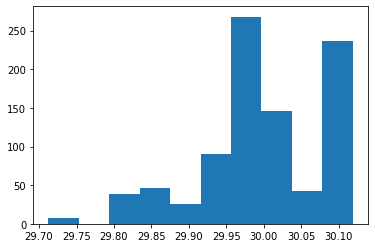

In [32]:
plt.hist(provamu[100:])

(array([ 14., 179., 132., 288., 100.,  16.,  56.,  70.,  17.,  29.]),
 array([0.42814936, 0.45772145, 0.48729353, 0.51686561, 0.5464377 ,
        0.57600978, 0.60558186, 0.63515394, 0.66472603, 0.69429811,
        0.72387019]),
 <a list of 10 Patch objects>)

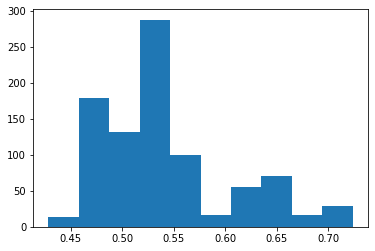

In [33]:
plt.hist(provatau[100:])

In [34]:
np.mean(provamu[100:])

29.99368

In [35]:
np.mean(provatau[100:])

0.5397487246628454

controlliamo il risultato plottando la posterior corretta

In [ ]:
#NO
def real_posterior(mu0,n,y):
    y= tfd.Normal(1/(1/sigma0**2 + n/sigma_obs**2)*(mu0/sigma0**2 + (np.sum(y)/sigma_obs**2)),1/(1/sigma0**2 + n/sigma_obs**2))   
    return y

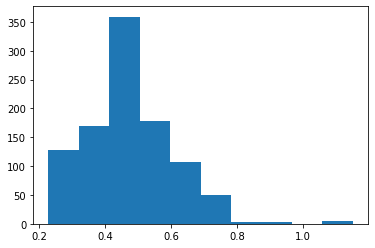

In [ ]:
#NO
import scipy.stats as stats
x = np.linspace(mu_obs - 3*np.sqrt(1/tau_obs), mu_obs + 3*np.sqrt(1/tau_obs), 100)

plt.hist(prova)
#plt.plot(x, 10*stats.norm.pdf(x,1/(1/sigma0**2 + n/sigma_obs**2)*(mu0/sigma0**2 + (np.sum(y_obs)/sigma_obs**2)), 1/(1/sigma0**2 + n/sigma_obs**2)))
plt.show()

MH restituisce delle μ sampled dalla prior e non dalla posterior 